<a href="https://colab.research.google.com/github/dkaikas/AI-in-Cybersecurity/blob/main/IDS_codelab_pcap_dataset_with_IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDS Deep Learning Notebook (with IPS Extension)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input


## Load and preprocess your dataset

In [2]:
def loadDataset():
    df = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/pcap_data.csv')

    feature_columns = df.columns[df.columns != 'target']
    label_column = 'target'

    data = df[feature_columns].values
    labels = df[label_column].astype(int).values

    # Normalize with Min-Max
    dmin, dmax = data.min(axis=0), data.max(axis=0)
    data = (data - dmin) / (dmax - dmin)

    # Train, Val, Test Split
    train_data, test_data, train_label, test_label = train_test_split(
        data, labels, test_size=0.20, stratify=labels)
    train_data, val_data, train_label, val_label = train_test_split(
        train_data, train_label, test_size=0.125, stratify=train_label)

    return train_data.astype('float32'), train_label.astype('int32'), \
           val_data.astype('float32'), val_label.astype('int32'), \
           test_data.astype('float32'), test_label.astype('int32')


In [3]:
train_data, train_labelp, val_data, val_labelp, test_data, test_labelp = loadDataset()

nclass = len(np.unique(train_labelp))
train_label = to_categorical(train_labelp, nclass)
val_label = to_categorical(val_labelp, nclass)
test_label = to_categorical(test_labelp, nclass)

inshape = train_data.shape[1]
train_data = train_data[..., np.newaxis]
val_data = val_data[..., np.newaxis]
test_data = test_data[..., np.newaxis]

print("Train shape:", train_data.shape)
print("Validation shape:", val_data.shape)
print("Test shape:", test_data.shape)
print("Number of classes:", nclass)


Train shape: (10476, 25, 1)
Validation shape: (1497, 25, 1)
Test shape: (2994, 25, 1)
Number of classes: 3


## Build and Train Conv1D Model

In [4]:
def create_model_conv1D(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model_conv1D((inshape, 1), nclass)
model.summary()

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labelp),
                                                  y=train_labelp)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

modelCheckPoint = ModelCheckpoint('./model_best.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(train_data, train_label,
                    validation_data=(val_data, val_label),
                    epochs=10,
                    batch_size=256,
                    callbacks=[modelCheckPoint],
                    class_weight=class_weights)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        94,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,723 (370.01 KB)

 Trainable params: 94,723 (370.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5085 - loss: 1.0274 - val_accuracy: 0.7495 - val_loss: 0.7633
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7536 - loss: 0.7169 - val_accuracy: 0.7876 - val_loss: 0.5871
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7969 - loss: 0.5927 - val_accuracy: 0.8049 - val_loss: 0.5402
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8091 - loss: 0.5500 - val_accuracy: 0.8297 - val_loss: 0.5021
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8204 - loss: 0.5297 - val_accuracy: 0.8350 - val_loss: 0.4864
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8315 - loss: 0.5047 - val_accuracy: 0.8517 - val_loss: 0.4644
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8344 - loss: 0.5023 - val_accuracy: 0.8597 - val_loss: 0.4465
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8470 - loss: 0.4722 - val_accuracy: 0.8657 - v

## Evaluate the Model and Display Confusion Matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


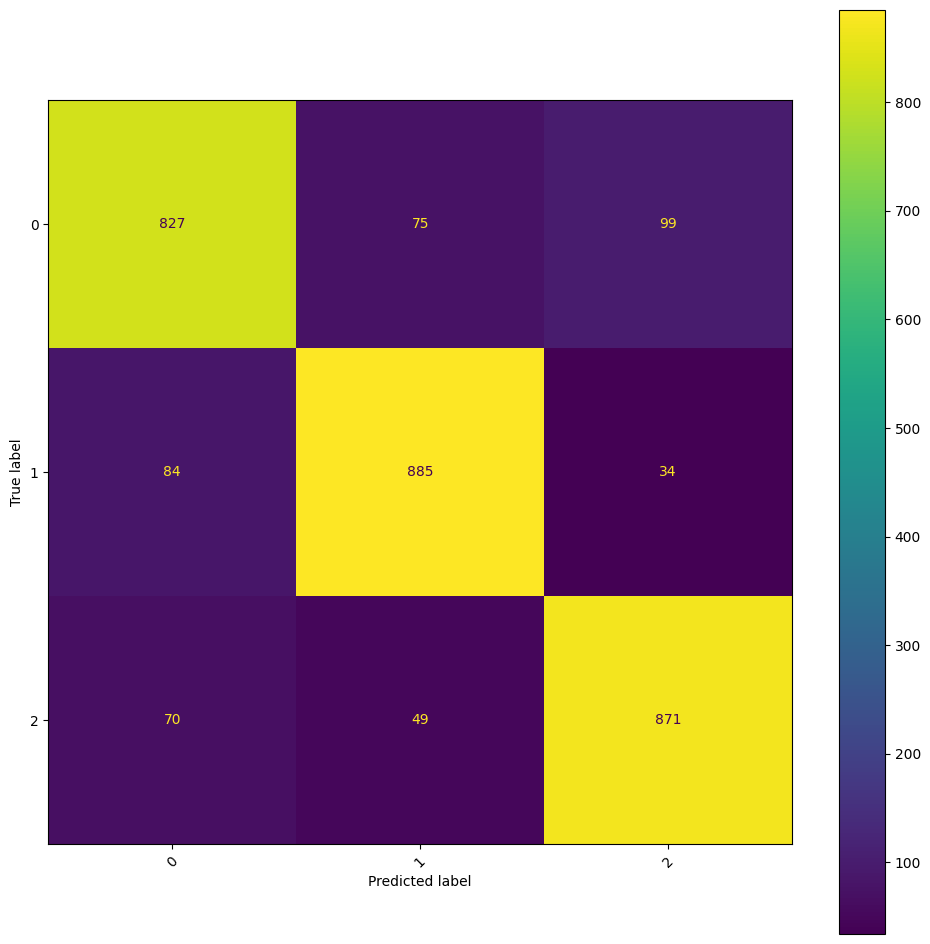

In [5]:
model.load_weights('./model_best.keras')
pred = model.predict(test_data)
pred_y = pred.argmax(axis=-1)

cm = confusion_matrix(test_labelp, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=45)
plt.show()


## Επέκταση σε IPS, Σύστημα Πρόληψης Εισβολών

In [6]:
label_map = {
    0: "Normal",
    1: "PortScan",
    2: "DDoS"
}

def respond_to_threat(predicted_class, confidence, source_ip=None):
    if predicted_class == 0:
        print("Κανονική κυκλοφορία.")
    elif predicted_class == 1:
        print(f"Εντοπίστηκε σάρωση θυρών (confidence: {confidence:.2f})")
        print(f"Αποκλεισμός IP προέλευσης: {source_ip}")
    elif predicted_class == 2:
        print(f"Εντοπίστηκε επίθεση DDoS (confidence: {confidence:.2f})")
        print("Απομόνωση τμήματος δικτύου.")
        print("Ειδοποίηση διαχειριστή...")
    else:
        print("Άγνωστη απειλή. Καταγραφή για περαιτέρω ανάλυση.")


In [7]:
sample = test_data[0].reshape(1, -1, 1)
prediction = model.predict(sample)
predicted_class = prediction.argmax()
confidence = prediction[0][predicted_class]

respond_to_threat(predicted_class, confidence, source_ip="192.168.1.101")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Εντοπίστηκε σάρωση θυρών (confidence: 0.62)
Αποκλεισμός IP προέλευσης: 192.168.1.101


## Plot Training History

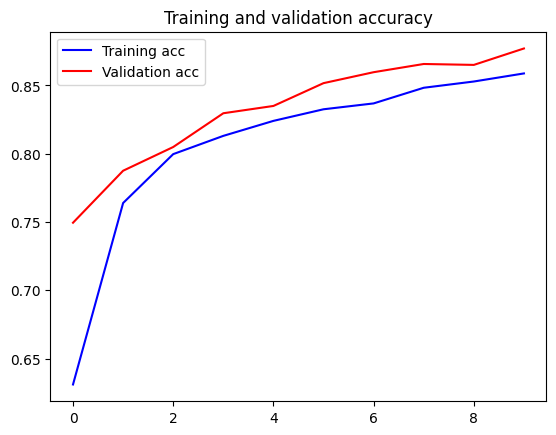

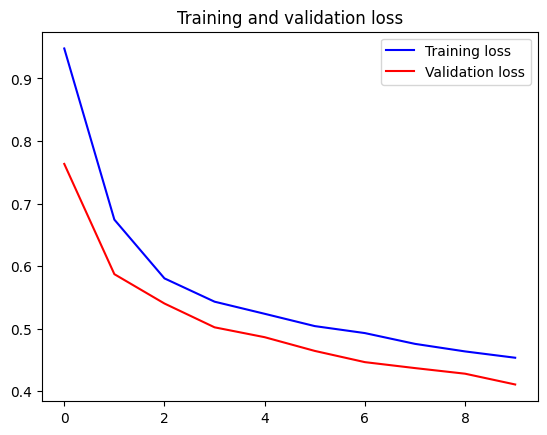

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))
plt.figure()
plt.plot(epochs_range, acc, 'b', label='Training acc')
plt.plot(epochs_range, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs_range, loss, 'b', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
